#Dependencies

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
import random
import scipy.stats as stats
from scipy.stats import ttest_ind
from scipy.stats import shapiro
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import mannwhitneyu

import statsmodels.api as sm
from statsmodels.formula.api import ols

# AB test
**Hypothesis:** we believe that if recruiters see unread candidate applies at the top of their inbox, the percentage of answered candidate applies will be higher.

**Main metric:** percentage of responses read by recruiters.

**Guardrail metric:** percentage of send answers by recruiters.

In [2]:
# we suppose that data collected properly for AB testing
df = pd.read_csv('/content/for_ab_test.csv')
df.head()

,grp,applies,read_applies,answered_applies
0,test,42,7,0
1,test,7,6,6
2,test,2,2,2
3,test,17,14,12
4,test,282,135,58


In [3]:
df['read_percentage'] = df['read_applies'] / df['applies']
df['answered_percentage'] = df['answered_applies'] / df['applies']
df['answered2read'] = np.where(
    df['read_applies']==0,
    0,
    df['answered_applies'] / df['read_applies']
    )

## EDA
Let's perform some Exploratory Data Analysis for better data understanding.

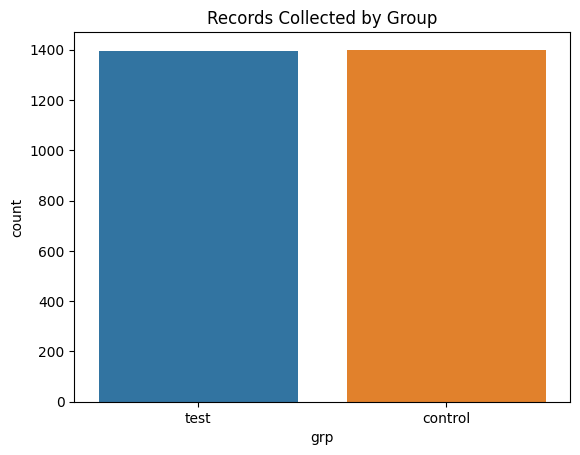

In [4]:
sns.countplot(data=df, x='grp', hue='grp')
plt.title('Records Collected by Group')
plt.show()

In [5]:
df.describe()

,applies,read_applies,answered_applies,read_percentage,answered_percentage,answered2read
count,2795.000000,2795.000000,2795.000000,2795.000000,2795.000000,2795.000000
mean,20.744544,10.129517,5.292308,0.559519,0.285025,0.377164
std,37.333786,21.084884,14.510162,0.395518,0.358466,0.412878
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1.000000,0.000000,0.142857,0.000000,0.000000
50%,9.000000,4.000000,1.000000,0.625000,0.078947,0.176471
75%,22.000000,11.000000,4.000000,1.000000,0.500000,0.833333
max,500.000000,482.000000,216.000000,1.000000,1.000000,1.000000


In [6]:
df.groupby('grp')[['read_percentage',	'answered_percentage',	'answered2read']].agg(['mean', 'median'])

read_percentage           answered_percentage           answered2read  \
                   mean    median                mean    median          mean   
grp                                                                             
control         0.53644  0.571429            0.270380  0.065942      0.367866   
test            0.58268  0.666667            0.299722  0.100000      0.386495   

                   
           median  
grp                
control  0.166667  
test     0.200000

Recruiters read just over half of all applications per group. On average, they respond to only about 27% of applications in the control group and 29.97% in the test group—a low response rate overall. Furthermore, for every application they respond to, recruiters need to read approximately 2.5 applications for both group.

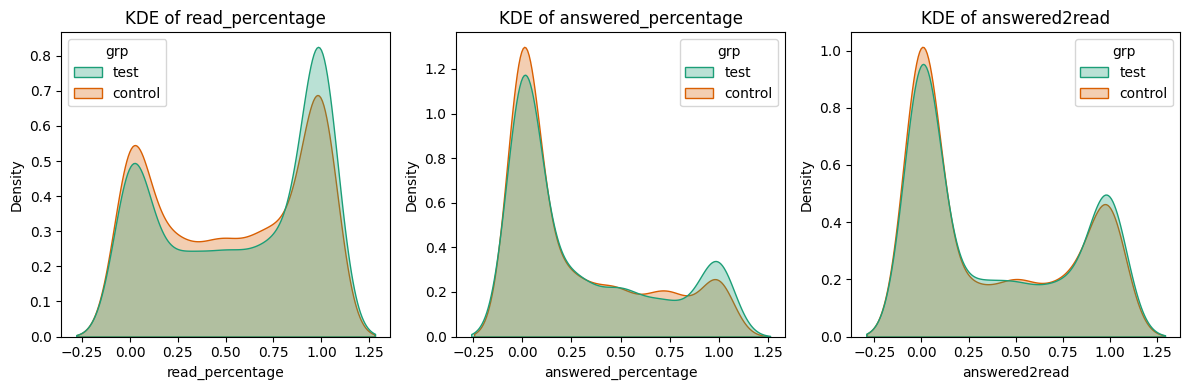

In [7]:
f, ax = plt.subplots(1, 3, figsize=(12, 4))

sns.kdeplot(data=df, x='read_percentage', hue='grp', palette='Dark2', fill=True, alpha=0.3, ax=ax[0])
ax[0].set_title('KDE of read_percentage')

sns.kdeplot(data=df, x='answered_percentage', hue='grp', palette='Dark2', fill=True, alpha=0.3, ax=ax[1])
ax[1].set_title('KDE of answered_percentage')

sns.kdeplot(data=df, x='answered2read', hue='grp', palette='Dark2', fill=True, alpha=0.3, ax=ax[2])
ax[2].set_title('KDE of answered2read')

plt.tight_layout()
plt.show()

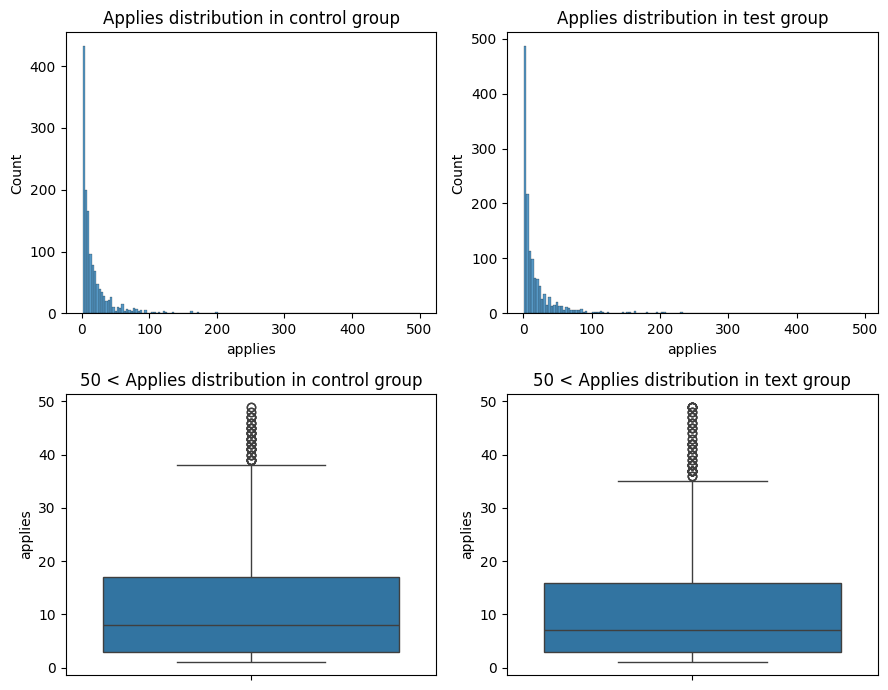

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(9, 7))

sns.histplot(data=df[df['grp'] == 'control'], x='applies', ax=ax[0, 0])
ax[0, 0].set_title('Applies distribution in control group')
sns.histplot(data=df[df['grp'] == 'test'], x='applies', ax=ax[0, 1])
ax[0, 1].set_title('Applies distribution in test group')

sns.boxplot(
    data=df[(df['grp'] == 'control') & (df['applies'] < 50)],
    y='applies',
    ax=ax[1, 0]
  )
ax[1, 0].set_title('50 < Applies distribution in control group')
sns.boxplot(
    data=df[(df['grp'] == 'test') & (df['applies'] < 50)],
    y='applies',
    ax=ax[1, 1]
  )
ax[1, 1].set_title('50 < Applies distribution in text group')

plt.tight_layout()
plt.show()

For future analysis, we can perform a cohort analysis by grouping records based on the total number of applications. For example, we could create groups like 1-5, 6-10, 11-20, 21-30, and 30+ applications.

## Bootstrap
With bootstrapping, we can determine the variability and confidence intervals for metrics like the mean, median or even other metrics.

In [109]:
def simple_bootstrapping(
    control_col: pd.DataFrame,
    test_col: pd.DataFrame,
    N=5000,
    metric='mean',
    diff_type='absolute',
    confidence_level=0.95,
    alternative='two-sided',
    print_plot=True,
    print_result=True,
    return_values=False):

  sample_length = max([len(control_col), len(test_col)])
  bootstrap_data = []

  # simulation
  for _ in tqdm(range(N)):
    control_sample = control_col.sample(sample_length, replace=True).agg(metric)
    test_sample = test_col.sample(sample_length, replace=True).agg(metric)

    # calculations can be performed in a relative or absolute way
    if diff_type=='relative':
      diff = (test_sample / control_sample - 1) * 100
    else:
      diff = test_sample - control_sample

    bootstrap_data.append(diff)

  bootstrap_data_series = pd.Series(bootstrap_data)
  # confidence interval for metric
  left_quant = (1 - confidence_level) / 2
  right_quant = 1 - (1-confidence_level) / 2
  ci = bootstrap_data_series.quantile([left_quant, right_quant])

  # p-value
  p_1 = stats.norm.cdf(
      x=0,
      loc=np.mean(bootstrap_data),
      scale=np.std(bootstrap_data)
  )

  p_2 = stats.norm.cdf(
      x=0,
      loc=-np.mean(bootstrap_data),
      scale=np.std(bootstrap_data)
  )

  if alternative=='one-sided':
    p_value = min([p_1, p_2])
  else:
    p_value = min([p_1, p_2]) * 2  # two_sided test

  # kde plot
  if print_plot:
    bootstrap_data_series.plot(kind='kde')
    plt.title(f'Density Plot of {metric.title()} Differences')
    plt.axvline(x=0, color='black', linestyle='--')
    plt.ylabel('Frequency')
    plt.xlabel('Bootstrap Data')
    plt.show()

  if print_result:
    print(f"Confidence Interval: {ci.values}")
    print(f"P-value: {round(p_value, 4)}")

  if return_values:
    return {
        "bootstrap_data": bootstrap_data,
        "confidence_interval": ci.values,
        "p_value": p_value
    }

**Read percentage mean difference**

  0%|          | 0/5000 [00:00<?, ?it/s]

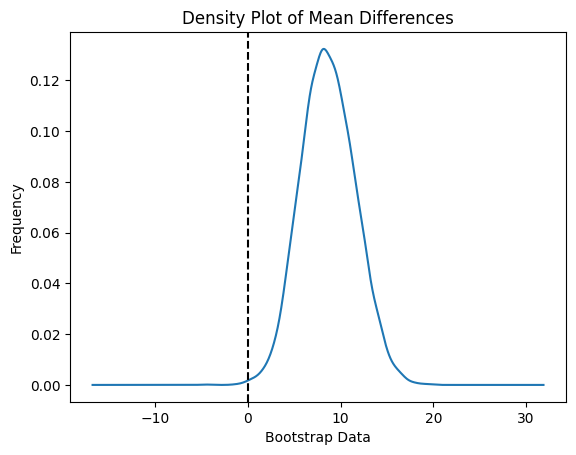

Confidence Interval: [ 3.20362349 14.3936548 ]
P-value: 0.0015


In [103]:
np.random.seed(42)
simple_bootstrapping(
    df[df['grp']=='control']['read_percentage'],
    df[df['grp']=='test']['read_percentage'],
    diff_type='relative',
    alternative='one-sided'
  )

There is significant difference.

**Answered percentage mean difference**

  0%|          | 0/5000 [00:00<?, ?it/s]

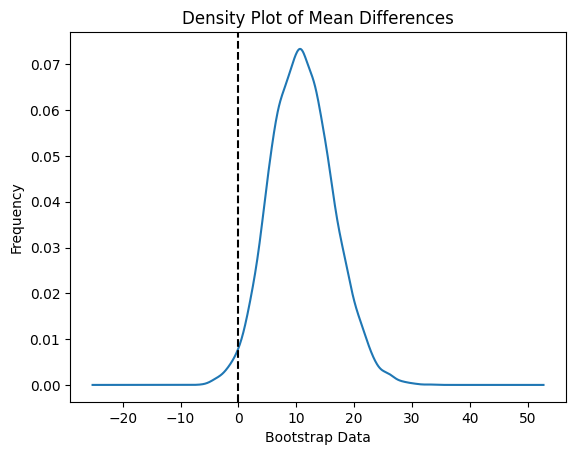

Confidence Interval: [ 1.05405664 21.84045782]
P-value: 0.0202


In [104]:
np.random.seed(42)
simple_bootstrapping(
    df[df['grp']=='control']['answered_percentage'],
    df[df['grp']=='test']['answered_percentage'],
    diff_type='relative',
    alternative='one-sided'
  )

There is significant difference.

**Answered to read mean difference**

  0%|          | 0/5000 [00:00<?, ?it/s]

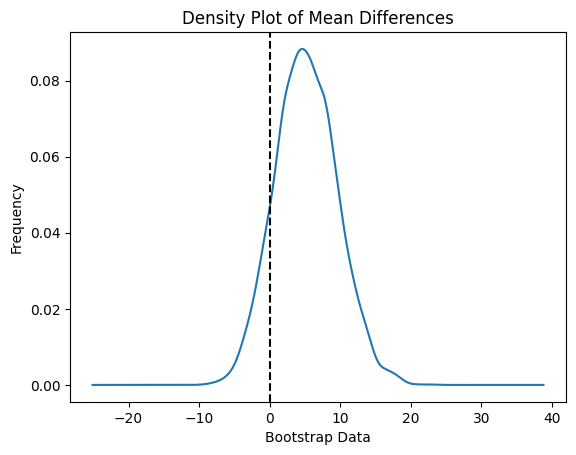

Confidence Interval: [-3.11555799 14.01532371]
P-value: 0.2351


In [105]:
np.random.seed(42)
simple_bootstrapping(
    df[df['grp']=='control']['answered2read'],
    df[df['grp']=='test']['answered2read'],
    diff_type='relative'
  )

There is not significant difference. Here I use two-sided test.

The guardrail metric shows no significant difference, which is a positive outcome, as we did not intend to influence it. Conversely, both the read percentage and answered percentage exhibit a significant difference, which is a favorable result for this A/B test. But I will back to that later.

## Statistical test
Statistical tests allow to compare only means.

In [111]:
def AB_Test(dataframe, group, target):

    # Split A/B
    groupA = dataframe[dataframe[group] == "control"][target]
    groupB = dataframe[dataframe[group] == "test"][target]

    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True

    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True

        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1]
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True

    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05],
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")

    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]

    # Print Hypothesis
    #print("# A/B Testing Hypothesis")
    #print("H0: A == B")
    #print("H1: A != B", "\n")

    return temp

In [126]:
stat_dataframe = pd.DataFrame({"Target": df.columns[4:]})
temp_df = pd.DataFrame()
for col in df.columns[4:]:
  result = AB_Test(dataframe=df, group="grp", target=col)
  temp_df = pd.concat([temp_df, result], ignore_index=True)

stat_dataframe = pd.concat([stat_dataframe, temp_df], axis=1)
stat_dataframe

,Target,Test Type,AB Hypothesis,p-value,Comment
0,read_percentage,Non-Parametric,Reject H0,0.001093,A/B groups are not similar!
1,answered_percentage,Non-Parametric,Reject H0,0.044300,A/B groups are not similar!
2,answered2read,Non-Parametric,Fail to Reject H0,0.137958,A/B groups are similar!


## Cohort analysis (ANOVA)

In [127]:
df['groups'] = pd.cut(
    df['applies'],
    bins=[0, 5, 10, 20, 31, float('inf')],
    labels=['1-5', '6-10', '11-20', '21-30', '30+']
)

In [129]:
df.head()

,grp,applies,read_applies,answered_applies,read_percentage,answered_percentage,answered2read,groups
0,test,42,7,0,0.166667,0.000000,0.000000,30+
1,test,7,6,6,0.857143,0.857143,1.000000,6-10
2,test,2,2,2,1.000000,1.000000,1.000000,1-5
3,test,17,14,12,0.823529,0.705882,0.857143,11-20
4,test,282,135,58,0.478723,0.205674,0.429630,30+


In [180]:
df[['groups', 'grp']].value_counts().reset_index().sort_values(by=['groups', 'grp'])

,groups,grp,count
1,1-5,control,505
0,1-5,test,557
3,6-10,control,257
6,6-10,test,230
2,11-20,control,259
7,11-20,test,227
8,21-30,control,142
9,21-30,test,125
5,30+,control,237
4,30+,test,256


In [136]:
group_df = df.groupby(['grp', 'groups'], observed=False)[['read_percentage', 'answered_percentage', 'answered2read']].mean().reset_index()
group_df

,grp,groups,read_percentage,answered_percentage,answered2read
0,control,1-5,0.561881,0.268911,0.313135
1,control,6-10,0.538504,0.264289,0.352716
2,control,11-20,0.548117,0.302564,0.436221
3,control,21-30,0.531967,0.289220,0.440671
4,control,30+,0.469912,0.233655,0.382592
5,test,1-5,0.600628,0.317594,0.359306
6,test,6-10,0.602008,0.294976,0.385961
7,test,11-20,0.622193,0.292798,0.407337
8,test,21-30,0.574428,0.317963,0.432451
9,test,30+,0.495258,0.262333,0.405212


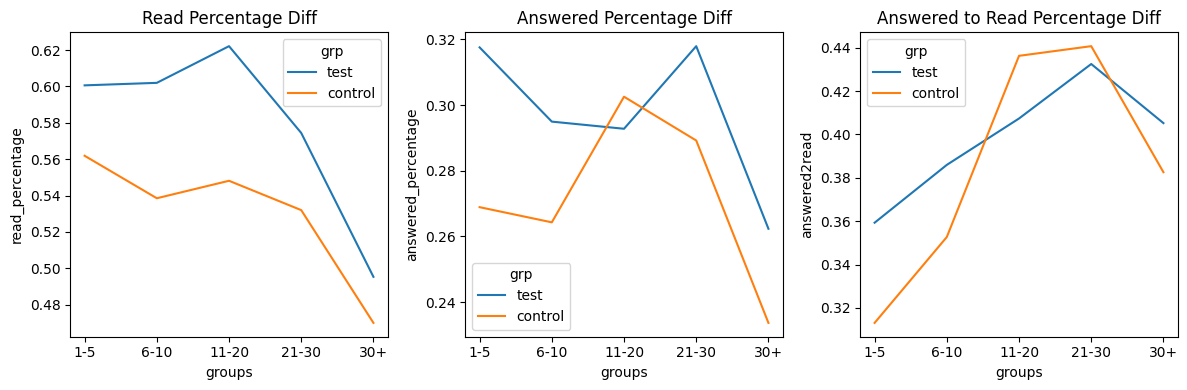

In [183]:
f, ax = plt.subplots(1, 3, figsize=(12, 4))

sns.lineplot(data=df, x='groups', y='read_percentage', hue='grp', errorbar=None, ax=ax[0])
ax[0].set_title('Read Percentage Diff')
sns.lineplot(data=df, x='groups', y='answered_percentage', hue='grp', errorbar=None, ax=ax[1])
ax[1].set_title('Answered Percentage Diff')
sns.lineplot(data=df, x='groups', y='answered2read', hue='grp', errorbar=None, ax=ax[2])
ax[2].set_title('Answered to Read Percentage Diff')

plt.tight_layout()
plt.show()

In [164]:
res = pd.DataFrame()

for group in df['groups'].unique():
  for col in df.columns[4:-1]:
    data = df[df['groups']==group]

    bootstrap_res = simple_bootstrapping(
        data[data['grp'] == 'control'][col],
        data[data['grp'] == 'test'][col],
        diff_type='relative',
        print_plot=False,
        print_result=False,
        return_values=True)

    upper_interval = bootstrap_res.get('confidence_interval')[1]
    lower_interval = bootstrap_res.get('confidence_interval')[0]
    p_value = bootstrap_res.get('p_value')

    confidence = None
    if (lower_interval < 0 < upper_interval) or (lower_interval > 0 > upper_interval):
      confidence = 'CI crosses 0'
    else:
      confidence = '95% CI level'

    temp_answer = pd.DataFrame([{
        'Group': group,
        'Target': col,
        'CI_upper': upper_interval,
        'CI_lower': lower_interval,
        'P_value': p_value,
        'Confidence': confidence
    }])
    res = pd.concat([res, temp_answer], ignore_index=True)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [170]:
res.sort_values(by=['Target', 'Group'])

,Group,Target,CI_upper,CI_lower,P_value,Confidence
8,1-5,answered2read,33.617542,-1.639425,0.093058,CI crosses 0
11,11-20,answered2read,9.566690,-20.188986,0.425832,CI crosses 0
14,21-30,answered2read,23.241382,-20.738954,0.937894,CI crosses 0
2,30+,answered2read,25.854605,-10.557131,0.499518,CI crosses 0
5,6-10,answered2read,33.242245,-8.836599,0.343262,CI crosses 0
7,1-5,answered_percentage,39.879559,0.962306,0.053790,95% CI level
10,11-20,answered_percentage,17.229974,-19.966871,0.763159,CI crosses 0
13,21-30,answered_percentage,44.604344,-16.016065,0.469799,CI crosses 0
1,30+,answered_percentage,40.025412,-10.355144,0.313323,CI crosses 0
4,6-10,answered_percentage,38.696538,-9.684713,0.319225,CI crosses 0


We cannot definitively say that the current group segmentation is causing the observed difference. Perhaps a different group distribution should be considered.

### ANOVA

In [173]:
model = ols('read_percentage ~ C(grp) * C(groups)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                      sum_sq      df          F    PR(>F)
C(grp)              1.551009     1.0  10.008606  0.001575
C(groups)           3.801009     4.0   6.131946  0.000066
C(grp):C(groups)    0.198843     4.0   0.320782  0.864204
Residual          431.584470  2785.0        NaN       NaN


There is a clear effect of test vs control overall. Groups segmented by the number of applications also show performance differences. The effect of the test is stable across groups — there’s no special segment where the test works better or worse.

In [174]:
model = ols('answered_percentage ~ C(grp) * C(groups)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                      sum_sq      df         F    PR(>F)
C(grp)              0.625592     1.0  4.877870  0.027284
C(groups)           0.958272     4.0  1.867961  0.113284
C(grp):C(groups)    0.284128     4.0  0.553850  0.696226
Residual          357.179363  2785.0       NaN       NaN


There is a obvious effect of test vs control overall. Groups segmented by the number of applications show no differences in performance. The effect of the test is stable across groups — there’s no special segment where the test works better or worse.

In [175]:
model = ols('answered2read ~ C(grp) * C(groups)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                      sum_sq      df         F    PR(>F)
C(grp)              0.323232     1.0  1.908842  0.167203
C(groups)           3.906121     4.0  5.766883  0.000128
C(grp):C(groups)    0.543913     4.0  0.803017  0.523097
Residual          471.595670  2785.0       NaN       NaN


There is no effect of test vs control overall. Groups segmented by the number of applications show some performance differences. The effect of the test is stable across groups — there’s no special segment where the test works better or worse.

# Conclusion
The test results are quite decent, showing significant changes in the main metric and no changes in guardrail (healthy metric). The problem, however, is that recruiters have started receiving outdated and irrelevant applications, causing disruptions in the recruitment process and leading to the rollback of this new feature. This experience only confirms that a well-formulated hypothesis is crucial in the A/B testing process.